# Praktikum 2

Tjark Pfeiffer und Fiona Lublow

## Lernziele

Zusätzliche zur Aufgabe, wollten wir genauer verstehen, warum das Modell 6 outputs gibt und damit z.B. die Loss-Funktion auch mit einem 6 dimensionalen Skalar vergleichen muss, obwohl wir outputs=3 definieren.

In [11]:
import torch
import deepinv
from torchvision import datasets, transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torchvision


In [3]:
print("PyTorch Version:", torch.__version__)
if torch.cuda.is_available():
    print("GPU is available.")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("GPU is not available. Using CPU instead.")

PyTorch Version: 2.9.1+cu128
GPU is available.
GPU Name: NVIDIA GeForce RTX 3070


## Vorgehen

Wir orientieren uns stark am [Deepia Beispiel](https://github.com/ytdeepia/DDPM/blob/main/src/training_minimal.py), ändern aber das Dataset von MNIST (grayscale) zu CIFAR-10 (3-Kanal Farbbild).
Das CIFAR-10 Dataset enthält Bilder aus 10 Kategorien, wir ignorieren die Labels und trainieren am ganzen Datensatz. Das kann dazu führen, das in den Bildern Mischungen "Mischwesen aus den Kategorien entstehen.

Wir versuchen die Bildqualität alle 10 Generationen zu vergleichen, und trainieren in unserem längsten Training insgesamt 100 Generationen.

In [5]:
device = "cuda"
batch_size = 128 # On RTX 3070: Memory Usage ~7800MiB/8192MiB (6800MiB für python process)
image_size = 32

transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)),
    ]
)
train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root="./data", train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)

lr = 1e-4
epochs = 10

scaler = torch.amp.GradScaler('cuda')

model = (deepinv.models.DiffUNet(in_channels=3,
                                out_channels=3,  # setting out_channels to 3, we expected this to produce a net with 3 outputs
                                pretrained=None)
                                .to(device))

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
mse = deepinv.loss.MSE()

beta_start = 1e-4
beta_end = 0.02
timesteps = 1000

loss_history = []

betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

for epoch in range(epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
    for data, _ in pbar:
        imgs = data.to(device)
        noise = torch.randn_like(imgs)
        t = torch.randint(0, timesteps, (imgs.size(0),), device=device)

        noised_imgs = (
            sqrt_alphas_cumprod[t, None, None, None] * imgs
            + sqrt_one_minus_alphas_cumprod[t, None, None, None] * noise
        )

        optimizer.zero_grad()

        estimated_noise = model(noised_imgs, t, type_t="timestep")
        estimated_noise = estimated_noise[:, :3, :, :] # fix output shape
        loss = mse(estimated_noise, noise)
        loss_scalar = loss.mean()
        loss_history.append(loss_scalar.item())
        loss_scalar.backward()
        optimizer.step()
        pbar.set_postfix({"loss": loss_scalar.item()})

torch.save(
    model.state_dict(),
    "trained_diffusion_model.pth",
)

Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

Wir müssen `estimated_noise` verändern, dass heißt 3 der outputs einfach ignorieren.

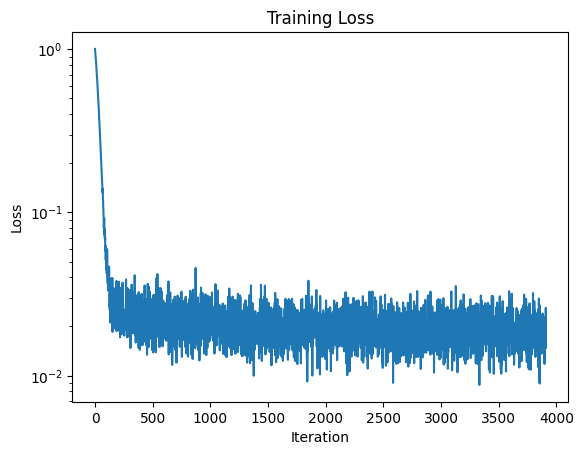

In [6]:
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training Loss")
plt.show()

In [7]:
from pathlib import Path

device = "cuda"
image_size = 32

checkpoint_path = "trained_diffusion_model.pth"
model = deepinv.models.DiffUNet(in_channels=3, out_channels=3, pretrained=Path(checkpoint_path)).to(device)

In [8]:
beta_start = 1e-4
beta_end = 0.02
timesteps = 1000
betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

model.eval()

n_samples = 32

In [9]:

@torch.no_grad()
def sample_no_variance(
    model,
    betas,
    image_size=32,
    batch_size=16,
    timesteps=1000,
    device="cuda",
):
    model.eval()
    betas = betas.to(device)

    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    sqrt_recip_alpha = torch.sqrt(1.0 / alphas)
    sqrt_one_minus_cumprod = torch.sqrt(1.0 - alphas_cumprod)

    # Initialize latent
    x_t = torch.randn(batch_size, 3, image_size, image_size, device=device)

    for t in range(timesteps - 1, -1, -1):
        ts = torch.full((batch_size,), t, device=device, dtype=torch.long)

        out = model(x_t, ts, type_t="timestep")
        eps = out[:, :3]           # ignore variance head completely

        # DDPM mean (same as in your full version)
        mean = (
            sqrt_recip_alpha[t]
            * (x_t - betas[t] * eps / sqrt_one_minus_cumprod[t])
        )

        if t > 0:
            noise = torch.randn_like(x_t)
            # standard DDPM fixed variance
            x_t = mean + torch.sqrt(betas[t]) * noise
        else:
            x_t = mean  # final step has no noise

    return x_t.clamp(-1, 1)


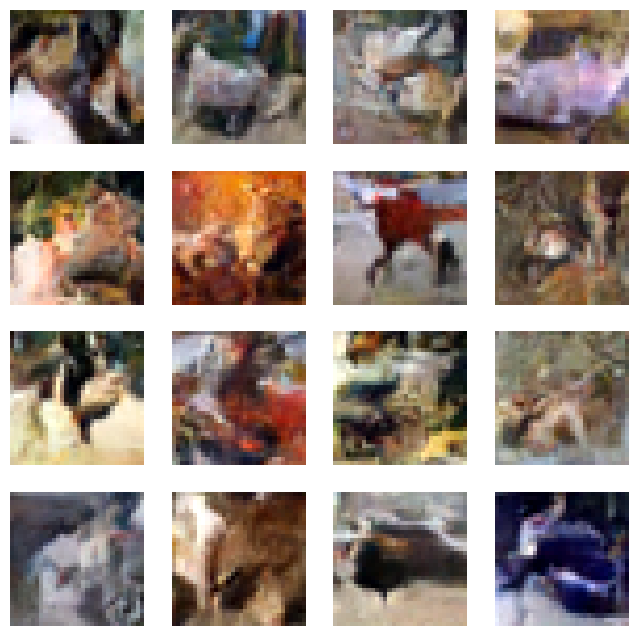

In [10]:
model.load_state_dict(torch.load("trained_diffusion_model.pth"))
model.to(device)

samples = sample_no_variance(
    model,
    betas=betas,
    image_size=32,
    batch_size=16,
    timesteps=timesteps,
    device=device,
)

grid = torchvision.utils.make_grid(imgs, nrow=4)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0).cpu().numpy())
plt.axis("off")
plt.show()

## Ergebnisse

### Bildqualität in verschiedener Trainingslänge

Die Bewertung ist subjektiv. Wir finden die Bilder aus höheren Generationen besser, bemerken aber, dass bereits nach 10 Generationen ein Großteil der "Qualität" erreicht ist. Das heißt, ein längeres Training erzeugt bessere Bilder, der Unterschied ist aber gering.

### Warum gibt das Modell 6 outputs?

Die Varianz, welche wir nicht nutzen, wird mit ausgegeben, um *verbesserte* DDPM trainieren zu können.
In der ursprünglichen DDPM Implementierung wird die Varianz ignoriert (Sec. 3.1 Ho et el. (2020)). So implementieren wir es auch, in dem wir die Varianz ignorieren.
Der Zweck der Varianz ist ein Training der Improved DDPM zu ermöglichen, wie es von Nichol and Dhariwal (2021) beschrieben wird. Hier wird die Varianz mittrainiert. Im Folgenden implementieren wir diese Trainingsmethode.

In [6]:
device = "cuda"
batch_size = 128
image_size = 32

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0)),
])

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root="./data", train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True,
)

lr = 1e-4
epochs = 10

scaler = torch.amp.GradScaler('cuda')

model = (
    deepinv.models.DiffUNet(
        in_channels=3,
        out_channels=3,   # → model will internally output 6 channels (2C)
        pretrained=None
    ).to(device)
)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

beta_start = 1e-4
beta_end = 0.02
timesteps = 1000

betas = torch.linspace(beta_start, beta_end, timesteps, device=device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1 - alphas_cumprod)

# Precompute true variances for KL term
posterior_variance = torch.zeros_like(betas)
posterior_variance[0] = betas[0]

# For t > 0:
posterior_variance[1:] = (
    betas[1:] * (1 - alphas_cumprod[:-1]) / (1 - alphas_cumprod[1:])
)

# A small weight (from the paper: 0.001 – 0.1)
lambda_var = 0.001

loss_history = []

for epoch in range(epochs):
    model.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)

    for imgs, _ in pbar:
        imgs = imgs.to(device)
        noise = torch.randn_like(imgs)
        t = torch.randint(0, timesteps, (imgs.size(0),), device=device)

        # forward diffusion q(x_t | x_0)
        x_t = (
            sqrt_alphas_cumprod[t, None, None, None] * imgs +
            sqrt_one_minus_alphas_cumprod[t, None, None, None] * noise
        )

        optimizer.zero_grad()

        # model predicts (eps, logvar)
        out = model(x_t, t, type_t="timestep")
        eps_pred = out[:, :3]       # first 3 channels
        logvar_pred = out[:, 3:]    # last 3 channels

        # -----------------------------------------
        # 1) epsilon (noise) prediction loss
        # -----------------------------------------
        loss_eps = torch.mean((eps_pred - noise) ** 2)

        # -----------------------------------------
        # 2) variance (log sigma^2) KL loss
        # -----------------------------------------
        # True variance for timestep t
        true_var = posterior_variance[t].view(-1, 1, 1, 1)
        true_logvar = torch.log(true_var + 1e-8)

        # L_var = 0.5 * ( log σ_t^2 - log σ̂_t^2 + (exp(log σ̂_t^2) / σ_t^2) - 1 )
        logvar_diff = true_logvar - logvar_pred
        var_ratio = torch.exp(logvar_pred) / (true_var + 1e-8)

        loss_var = 0.5 * (logvar_diff + var_ratio - 1)
        loss_var = loss_var.mean()

        # Combined Improved DDPM loss
        loss = loss_eps + lambda_var * loss_var

        loss.backward()
        optimizer.step()

        loss_history.append(loss.item())
        pbar.set_postfix({"loss": loss.item()})


torch.save(model.state_dict(), "trained_diffusion_model_var.pth")


Epoch 1/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 2/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 3/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 4/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 5/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 6/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 7/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 8/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 9/10:   0%|          | 0/391 [00:00<?, ?it/s]

Epoch 10/10:   0%|          | 0/391 [00:00<?, ?it/s]

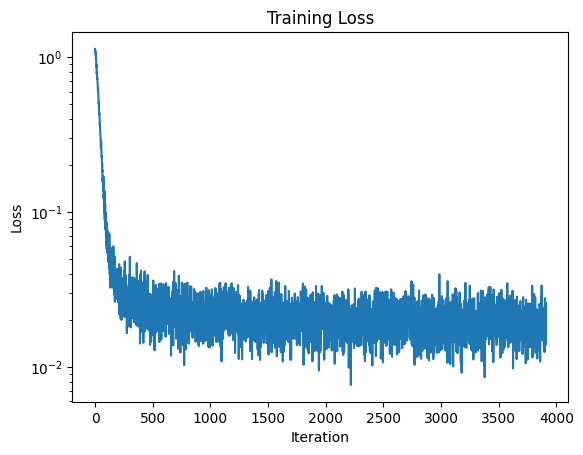

In [7]:
plt.plot(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training Loss")
plt.show()

In [16]:
@torch.no_grad()
def sample_learned_logvar(
    model,
    betas,
    image_size=32,
    batch_size=16,
    timesteps=1000,
    device="cuda",
    clamp_min=-20.0,
    clamp_max=20.0,
):
    model.eval()
    betas = betas.to(device)

    alphas = 1.0 - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    sqrt_recip_alpha = torch.sqrt(1.0 / alphas)
    sqrt_one_minus_cumprod = torch.sqrt(1.0 - alphas_cumprod)

    # DDPM posterior variance (used for t=0 and for reference)
    posterior_variance = torch.zeros_like(betas)
    posterior_variance[0] = betas[0]
    posterior_variance[1:] = betas[1:] * (1 - alphas_cumprod[:-1]) / (1 - alphas_cumprod[1:])

    x_t = torch.randn(batch_size, 3, image_size, image_size, device=device)

    for t in range(timesteps - 1, -1, -1):
        ts = torch.full((batch_size,), t, device=device, dtype=torch.long)

        out = model(x_t, ts, type_t="timestep")
        eps = out[:, :3]
        logvar = out[:, 3:]                     # learned LOG variance

        # clamp learned logvar to safe range
        logvar = torch.clamp(logvar, clamp_min, clamp_max)
        var = torch.exp(logvar)

        # DDPM mean
        mean = (
            sqrt_recip_alpha[t] *
            (x_t - betas[t] * eps / sqrt_one_minus_cumprod[t])
        )

        if t > 0:
            noise = torch.randn_like(x_t)
            x_t = mean + torch.sqrt(var) * noise
        else:
            x_t = mean

    return x_t.clamp(-1, 1)


In [17]:
model.load_state_dict(torch.load("trained_diffusion_model_var.pth"))
model.to(device)

samples = sample_learned_logvar(
    model,
    batch_size=16,
    image_size=32,
    timesteps=1000,
    betas=betas,      # same betas used in training
    device=device
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.28602502..1.0].


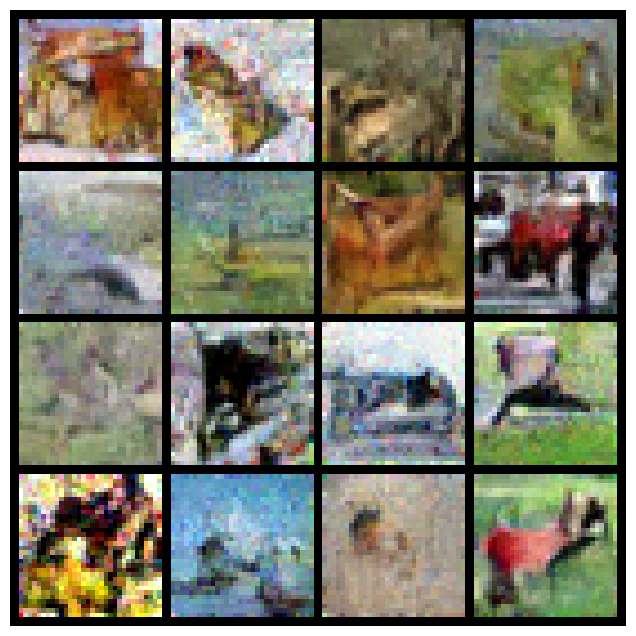

In [18]:
grid = torchvision.utils.make_grid(samples, nrow=4)
plt.figure(figsize=(8,8))
plt.imshow(grid.permute(1,2,0).cpu())
plt.axis("off")
plt.show()

## Ergebnisse verbesserte DDPM


Wir haben ein verbessertes DDPM trainiert, und beobachten ein etwas anderes Lernverhalten. Der Loss sinkt anfangs ähnlich stark, aber die Kurve ist weniger abrupt.

| Without Variance                                                      | With Variance                                                |
|:----------------------------------------------------------------------|:-------------------------------------------------------------|
| ![Loss without Variance](loss_noVariance.png "No Variance")  | ![Loss with Variance](loss_withVariance.png "With Variance") |

In den Bildern können wir keinen Unterschied erkennen, es ist aber klar, dass wir die Varianz richtig in das Training und das Sampling aufgenommen haben.

| Without Variance                                                       | With Variance                                                           |
|:-----------------------------------------------------------------------|:------------------------------------------------------------------------|
| ![Images without Variance](10generations_noVariance.png "No Variance") | ![Images with Variance](10generations_withVariance.png "With Variance") |

## Reflexion

Obwohl die grundsätzliche Funktionsweise der Diffusion verstanden und relativ klar war, zeigt die Verwirrung um die Outputs erneut, dass die Details von ML-Anwendungen häufig enorm kompliziert sind. Jede Kleinigkeit, die im Paper nur kurz erwähnt wird, kann eine Komplexität haben, die wirklich zu verstehen, mehrere Stunden benötigen kann.
